**Data 604 Final Project: Queuing at Airport Terminals**

Trishita Nath

18th July 2021

**Problem Statement and its significance**

One of the key factors that determines the quality of services offered at airport terminals is the wait time experienced when undergoing security screening. With the emergence of COVID-19, airport terminals have also become points for Corona Virus testing.

In this project, I will be simulating a hypothetical airport terminal that provides two services:
1.   Security screening
2.   COVID testing

These services are accessed by only one queue, but the service time is as follow:
*   Security screening services follow a triangular model with a mean of 4mins, a lower end of 3 mins, and an upper value of 5 mins
*   COVID services follow a triangular model with a mean of 15 mins, with a low of 10 and high of 20

Traveller arrival rate is generated randomly using an exponential distribution with an arrival rate of 5 to 10 customers every hour. Each run of the simulation covers 24 hours (Airport terminals are open all day)

**Flow Chart Model**



**Simulate the process for the appropriate number of iterations**

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
!pip install simpy

In [2]:
#Import required libraries
import simpy
import numpy as np
import pandas as pd
import random

In [3]:
# Seed and simulation time
seed = 500
simulation_time = 24 # Airport operational hours

np.random.seed(seed)
# global report variable
report = pd.DataFrame(columns = ['Traveller Id', 'Service', 'Arrival Time', 'Token Time', 'Service Start Time', 'Service Stop Time'])

,Traveller Id,Service,Arrival Time,Token Time,Service Start Time,Service Stop Time


In [4]:
#Function to generate arrival, 5 to 10 travellers every hour (busy airport)
def generate_interarrival(): #Arrival rate 1 - 20 per hour
    return np.random.exponential(60.0/np.random.randint(40,80))

In [5]:
#Function to return time generated for security scanning service
def security_service():
    return np.random.triangular(3,4,5)

In [6]:
#Function to return time generated for COVID testing servive
def covid_service():
    return np.random.triangular(10,15,20)

In [7]:
def airport_run(env,  security, covid):
    global current_hour
    i = 0 # traveller counter
    while True: #running time = 24 hours

        Service = np.random.choice(['Security', 'COVID'], p=[0.85, 0.15]) #random.choices(services, weights=(10, 90)   
        i += 1
        yield env.timeout(generate_interarrival())
        env.process(traveller(env, i,  security, covid, Service))

In [8]:
#function generates report for each traveller
def traveller(env, traveller, security, covid, Service):
    
    global report #access the global variable

    if Service == 'COVID':
        req = covid
    else:
        req = security
    
    with covid.request() as request:
        arrival_time = env.now #starts the clock
        #print(arrival_time, '\tCustomer {} arrives'.format(customer))
        yield env.timeout(1/2) # Token generation time of 30 seconds
        token_time = env.now #records time at which token is taken
        #print(token_time, '\tCustomer {} took a token'.format(customer))
        yield request
        service_start_time = env.now #service starts 
        #print(service_start_time, '\tCustomer {} is being served at {}'.format(customer, Service))
        if Service == 'COVID':
            yield env.timeout(covid_service())
        else:
            yield env.timeout(security_service())
        service_stop_time = env.now 
        #record the data generated
        row = pd.DataFrame([['Traveller_{}'.format(traveller), Service, arrival_time, token_time, service_start_time, service_stop_time]],
                          columns = ['Traveller Id', 'Service', 'Arrival Time', 'Token Time','Service Start Time', 'Service Stop Time'])
       
        report = report.append(row, ignore_index = True, sort = False)
        #Calculations for wait time
        report['Token Time (Secs)'] =  60 * ( report['Token Time'] - report['Arrival Time'])
        report['Service Time (Mins)'] =  (report['Service Stop Time'] - report['Service Start Time'])
        report['Wait Time (Mins)'] =  ( report['Service Start Time'] - report['Token Time'] )

In [9]:
#Running it in a model
def model(nruns, nsecurity, ncovid): #pass in no of runs for simulation, security capacity, covid capacity
    #initialise
    Security=[] 
    COVID=[]
    avg_wait_time = []
    covid_wait_time = []
    security_wait_time = []
    global report
    for j in range(nruns):
        report = report[0:0]
        env = simpy.Environment()
        env.initial_time = 0
        # resource
        security = simpy.Resource(env, capacity=nsecurity) #assign security as resource
        covid = simpy.Resource(env, capacity=ncovid) #assign covid as resource
        env.process(airport_run(env, security, covid))
        env.run(until = 12 * 60) #run for 12 hours
        
        
        COVID=report[report.Service.isin(['COVID'])] #separate to calculate mean later
        Security=report[report.Service.isin(['Security'])]
    
        avg_wait=report['Wait Time (Mins)'].mean() #Calculate average time
        avg_wait_security=Security['Wait Time (Mins)'].mean()
        avg_wait_covid=COVID['Wait Time (Mins)'].mean()
    
        #print('Average wait time:', avg_wait)
        #print('Average wait time teller:', avg_wait_teller)
        #print('Average wait time exchange:', avg_wait_exchange)
    
        avg_wait_time.append(avg_wait)
        covid_wait_time.append(avg_wait_covid)
        security_wait_time.append(avg_wait_security)
        
    #Save in a dataframe
    new_dict = {"avg_wait": avg_wait_time, "covid_wait": covid_wait_time, "security_wait": security_wait_time }
    
    global new_df
    new_df = pd.DataFrame(new_dict)
    fig=new_df.boxplot(grid=False, widths=0.5)
    return new_df
    return fig

,avg_wait,covid_wait,security_wait
0,254.507645,306.560646,249.342080
1,301.584878,263.998205,307.501299
2,273.252293,289.849004,270.560934
3,258.789948,275.433294,255.915189
4,288.321968,274.037698,291.068943
5,288.042268,307.301504,284.190421
6,269.872651,307.069251,263.205336
7,292.928244,282.193028,294.799520
8,272.152124,330.239432,262.646928
9,289.398641,292.771715,288.625645


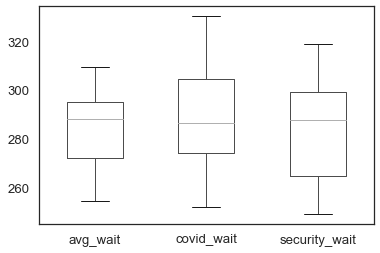

In [10]:
np.random.seed(5000)
model(14,5,1) # running the simulation 14 times to simulate 2 weeks

**Verification and Validation**

I verified by printing and checking intermediate outputs while writing the code. Each run of the simulation generates a report like the one below. The service stop time is compares with the service start of the next traveller and do not overlap.

Validation is a bit hard here because I am working on a hypothetical situation and I do not have a dataset to compare the results to. However, the flow of the travellers in the report losely mimics the actual wait times experienced in a typical airport.


In [11]:
report

,Traveller Id,Service,Arrival Time,Token Time,Service Start Time,Service Stop Time,Token Time (Secs),Service Time (Mins),Wait Time (Mins)
0,Traveller_1,Security,0.428879,0.928879,0.928879,4.983967,30.0,4.055088,0.000000
1,Traveller_2,Security,0.585554,1.085554,4.983967,9.416074,30.0,4.432107,3.898413
2,Traveller_3,Security,1.228526,1.728526,9.416074,13.667301,30.0,4.251227,7.687548
3,Traveller_4,COVID,1.732747,2.232747,13.667301,30.130449,30.0,16.463147,11.434555
4,Traveller_5,Security,2.673187,3.173187,30.130449,34.288565,30.0,4.158116,26.957262
...,...,...,...,...,...,...,...,...,...
120,Traveller_121,Security,132.624283,133.124283,684.290031,688.580175,30.0,4.290144,551.165748
121,Traveller_122,Security,133.101501,133.601501,688.580175,693.211599,30.0,4.631424,554.978674
122,Traveller_123,COVID,133.766469,134.266469,693.211599,709.610775,30.0,16.399176,558.945130
123,Traveller_124,Security,134.013557,134.513557,709.610775,713.386759,30.0,3.775984,575.097218


In [12]:
# Verifying the output during each run
print('Avg wait:',report['Wait Time (Mins)'].mean())
COVID=report[report.Service.isin(['COVID'])]
print('Avg covid wait:',COVID['Wait Time (Mins)'].mean())
Security=report[report.Service.isin(['Security'])]
print('Avg security wait:',Security['Wait Time (Mins)'].mean())

Avg wait: 296.07745707285994
Avg covid wait: 269.3418447634796
Avg security wait: 300.8696894679376



**Conclusions/ findings from the model**

An average wait time of more than an hour is long and renders the system sluggish in serving travellers.

I ran the simulation multiple times and below are the findings.


<AxesSubplot:ylabel='Frequency'>

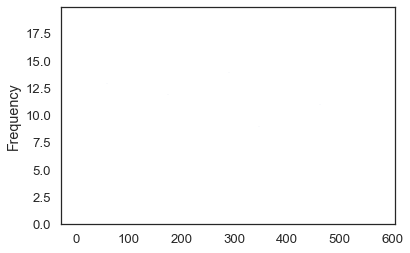

In [13]:
report['Wait Time (Mins)'].plot.hist(width = 1.2)

<AxesSubplot:>

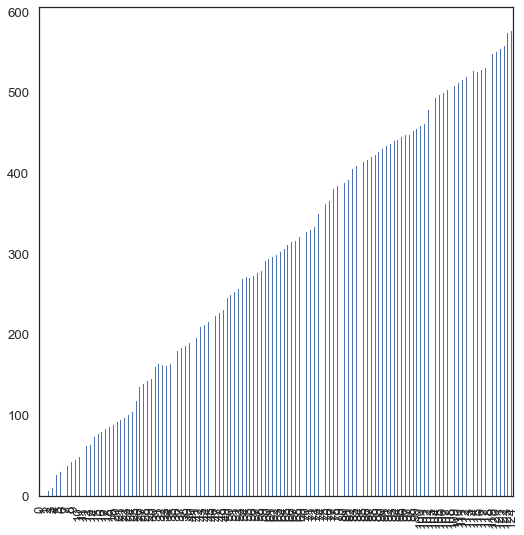

In [14]:
report['Wait Time (Mins)'].plot.bar(figsize=(8.5,9))

<AxesSubplot:>

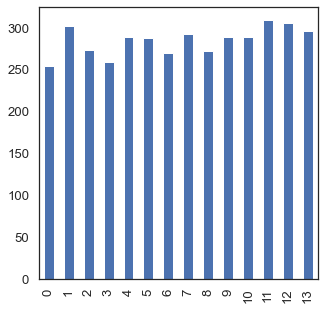

In [15]:
new_df['avg_wait'].plot.bar(figsize=(5,5))

<AxesSubplot:>

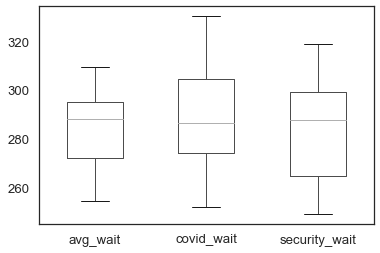

In [16]:
new_df.boxplot(grid=False, widths=0.5)

**Presentation**

My Powerpoint presentation is found on github: https://github.com/nathtrish334/Data-604/blob/main/Presentation.pptx